# Process Data

In [1]:
import pandas as pd
debian_mailing_list = pd.read_csv("./debian-user-filtered.dat", header = None)

In [2]:
processed_dml = []
for items in debian_mailing_list[0]:
    link = [int(s) for s in items.split(" ")]
    processed_dml.append(link)

In [3]:
threads_dict = {}
for link in processed_dml:
    thread_id = link[4]
    if thread_id not in threads_dict:
        threads_dict.update({thread_id : [link[0:5]]})
    else:
        threads_dict[thread_id].append(link[0:5])

In [4]:
initial_time = processed_dml[0][0]
current_time = initial_time
interval = 2880 #mimutes
temporal_graph = {}
i = 0
for link in processed_dml:
    time_stamp = link[0]
    if time_stamp >= current_time and time_stamp <= current_time + interval*60:
        if i not in temporal_graph:
            temporal_graph.update({i : [link[1:3]]})
        else:
            temporal_graph[i].append(link[1:3])
    else:
        i = i + 1
        current_time = time_stamp
        if i not in temporal_graph:
            temporal_graph.update({i : [link[1:3]]})
        else:
            temproal_graph[i].append(link[1:3])

In [5]:
import random
char_set = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
color_set = []

for i in range(1000):
    color_code = '#'
    for j in range(6):
        index = random.randint(0, 15)
        color_code += char_set[index]
    if color_code not in color_set:
        color_set.append(color_code)

# Louvain for each snapshot

In [6]:
import community
import networkx as nx
import matplotlib.pyplot as plt
def snapshot(edge_list):
    G = nx.Graph()
    #add nodes
    node_list = []
    for edge in edge_list:
        for node in edge:
            if node not in node_list:
                node_list.append(node)
    G.add_nodes_from(node_list)
    
    #add edges
    G.add_edges_from(edge_list)
    return G

C:\Users\tungu\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


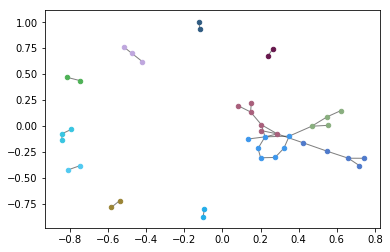

In [7]:
%matplotlib inline

edge_list = temporal_graph[3201]
G = nx.Graph()
#add nodes
node_list = []
for edge in edge_list:
    for node in edge:
        if node not in node_list:
            node_list.append(node)
G.add_nodes_from(node_list)

#add edges
G.add_edges_from(edge_list)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = color_set[count])
    count = count + 1


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Link Stream (First Attempt)

In [8]:
import math
def sort(l):
    a = l[0]
    b = l[1]
    if a < b:
        return [a,b]
    else:
        return [b,a]
    
time_step = 24 * 60 * 7 #minutes

class LinkStream:
    def __init__(self, vertices = set(), links=[]):
        self.vertices = vertices
        self.links = links
        self.hard_temporal_graph = {}
        self.weighted_temporal_graph = {}
        self.partition = []
        self.init_time = 0
        self.finial_time = 0
        
    def construct_from_threads(self, threads):
        self.vertices = []
        self.links = []
        for thread in threads:
            for item in thread:
                for i in item[1:3]:
                    self.vertices.append(i)
                self.links.append(item[0:5])
                
    def construct_temporal_graphs(self, interval = time_step, extended_link = 2):
        #construct hard temporal graph
        init_time = self.links[0][0]
        final_time = self.links[-1][0]
        for link in self.links:
            time = link[0]
            if time < init_time:
                init_time = time
            if time > final_time:
                final_time = time
        self.init_time = init_time
        self.final_time = final_time
                
        for link in self.links:
            time_stamp = link[0]
            index = math.floor((time_stamp - init_time) / (interval*60))
            if index not in self.hard_temporal_graph:
                G = nx.Graph()
                G.add_nodes_from(link[1:3])
                G.add_edge(link[1], link[2])
                self.hard_temporal_graph.update({index : G})
            else:
                self.hard_temporal_graph[index].add_nodes_from(link[1:3])
                self.hard_temporal_graph[index].add_edge(link[1], link[2])
                
        final_step = math.floor((final_time - init_time) / (interval*60))
        for i in range(final_step):
            if i not in self.hard_temporal_graph:
                self.hard_temporal_graph.update({i : nx.Graph()})
                
        #construct weighted temporal graph
        for index in self.hard_temporal_graph:
            G = self.hard_temporal_graph[index]
            wG = nx.Graph()
            for node in G.nodes:
                wG.add_node(node)
            for edge in G.edges:
                wG.add_edge(edge[0], edge[1], weight = 1)
            
            if index == 0:
                self.weighted_temporal_graph.update({index: wG})
                continue
                
            i = index - 1
            j = 1
            while i >= 0:
                if j > extended_link:
                    break
                prev_graph = self.hard_temporal_graph[i]
                for edge in prev_graph.edges:
                    if edge in wG.edges:
                        continue
                    else:
                        wG.add_nodes_from(edge)
                        wG.add_edge(edge[0], edge[1], weight = 1)
                i = i-1
                j = j+1
            self.weighted_temporal_graph.update({index: wG})
    
    def discretize(self, thread, interval):
        init_time = self.links[0][0]
        thread_init_time = thread[0][0]
        thread_final_time = thread[0][0]
        for link in thread:
            time = link[0]
            if time < thread_init_time:
                thread_init_time = time
            if time > thread_final_time:
                thread_final_time = time
        discrete_init_time = math.floor((thread_init_time - init_time)/(interval * 60))
        discrete_final_time = math.floor((thread_final_time - init_time)/(interval * 60))
        
        Ti = discrete_final_time - discrete_init_time + 1
        T = len(self.weighted_temporal_graph)
        return [Ti, T, discrete_init_time, discrete_final_time]
        
    def link_delta(self, u, v, thread, interval = time_step):
        Ti, T, discrete_init_time, discrete_final_time = self.discretize(thread, interval)
        
        numerator = 0
        for i in range(discrete_init_time, discrete_final_time+1):
            if (u,v) not in self.weighted_temporal_graph[i].edges:
                continue
            numerator += self.weighted_temporal_graph[i][u][v]['weight']
            
        denominator = 0
        for i in range(T):
            if (u,v) not in self.weighted_temporal_graph[i].edges:
                continue
            denominator += self.weighted_temporal_graph[i][u][v]['weight']
            
        return (numerator / (denominator)) * (T / Ti)
    
    def thread_delta(self, thread, interval = time_step):
        result = 0
        for link in thread:
            result += self.link_delta(link[1], link[2], thread, interval) 
        return result
        
    def expected_link_delta(self, u, v, thread, interval = time_step):
        Ti, T, discrete_init_time, discrete_final_time = self.discretize(thread, interval)
        denominator = 0
        for i in range(T):
            G = self.weighted_temporal_graph[i]
            total_strength = 0
            for edge in G.edges:
                total_strength += 2*G[edge[0]][edge[1]]['weight']
            u_strength = 0
            for node in G.nodes:
                if (u, node) in G.edges:
                    u_strength += G[u][node]['weight']
            v_strength = 0
            for node in G.nodes:
                if (v, node) in G.edges:
                    v_strength += G[v][node]['weight']
                    
            denominator += u_strength * v_strength / (total_strength-1)
            
        if denominator == 0:
            print(thread)
            return 0
            
        numerator = 0
        for i in range(discrete_init_time, discrete_final_time + 1):
            G = self.weighted_temporal_graph[i]
            total_strength = 0
            for edge in G.edges:
                total_strength += 2*G[edge[0]][edge[1]]['weight']
            u_strength = 0
            for node in G.nodes:
                if (u, node) in G.edges:
                    u_strength += G[u][node]['weight']
            v_strength = 0
            for node in G.nodes:
                if (v, node) in G.edges:
                    v_strength += G[v][node]['weight']
            numerator += u_strength * v_strength / (total_strength-1)

        return (numerator / (denominator)) * T/Ti
    
    def expected_thread_delta(self, thread, interval = time_step):
        Ti, T, discrete_init_time, discrete_final_time = self.discretize(thread, interval)
        result = 0
        for i in range(discrete_init_time, discrete_final_time+1):
            G = self.weighted_temporal_graph[i]
            involved_nodes = []
            for link in thread:
                time = link[0]
                j = math.floor((time - self.init_time) / (interval * 60))
                if j == i:
                    for node in link[1:3]:
                        if node not in involved_nodes:
                            involved_nodes.append(node)
                            
            for node_1 in involved_nodes:
                for node_2 in involved_nodes:
                    if node_1 == node_2:
                        continue
                    result += self.expected_link_delta(node_1, node_2, thread, interval)/2

        return result
    
    def modularity(self, partition, interval=time_step):
        
        score = 0
        for thread in partition:
            score += self.expected_thread_delta(thread, interval)
            
        return score

In [9]:
L = LinkStream()
test_threads = []
i = 0
for item in threads_dict:
    test_threads.append(threads_dict[item])
    i += 1
    if i > 100:
        break
L.construct_from_threads(test_threads)
L.construct_temporal_graphs()

In [28]:
def partition(lst, n): 
    division = len(lst) / float(n) 
    return [ lst[int(round(division * i)): int(round(division * (i + 1)))] for i in range(n) ]

In [29]:
randomed_partition = partition(L.links, 10)

In [209]:
single_element_threads = []
for thread in test_threads:
    for link in thread:
        single_element_threads.append([link])

In [824]:
L.modularity(randomed_partition)

165.4319832570818

In [825]:
L.modularity(test_threads)

194.3324699940387

In [826]:
L.modularity(single_element_threads)

317.60354611878995

In [641]:
S = LinkStream()
S.links = [[1,2,3],[2,1,2]]
partitions = [[[1,2,3]],[[2,1,2]]]

In [642]:
S.construct_temporal_graphs(interval = 1/60)

In [643]:
S.weighted_temporal_graph[1].edges

EdgeView([(1, 2)])

In [644]:
if (3,2) in S.weighted_temporal_graph[1].edges:
    print('la')

In [645]:
S.modularity(partitions, interval = 1/60)

2.0
2.0
2.0
2.0


0.0

# Greedy Search

In [4]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

def union(lst1, lst2):
    lst3 = lst1
    for value in lst2:
        if value not in lst3:
            lst3.append(value)
    return lst3

def max_intersection_thread(cluster, ground_truth_partition):
    max_intersection = 0
    max_thread = None

    for thread in ground_truth_partition:
        intersect = intersection(cluster, thread)
        if max_intersection < len(intersect):
            max_intersection = len(intersect)
            max_thread = thread
    return (max_thread, max_intersection)

In [5]:
def partition_score(partition, ground_truth_partition):
    final_score = 0
    for cluster in partition:
        match_thread, intersect = max_intersection_thread(cluster, ground_truth_partition)
        cluster_score = intersect / len(union(cluster, match_thread))
        final_score += cluster_score
    return final_score / len(partition)

In [45]:
randomed_partition = partition(L.links, 120)

In [46]:
partition_score(randomed_partition, test_threads)

0.45164652477152506

In [48]:
partition_score(single_element_threads, test_threads)

0.4786729857819906

In [41]:
# simple test
gtp = [[1,2,3],[4,5,6],[7,8,9]]
p = [[1,2,3,4],[5,6,7],[8,9]]
partition_score(p, gtp)

0.6388888888888888

In [29]:
def time_stamp(link):
    return link[0]

def node_set(thread):
    node_set = []
    for link in thread:
        for node in link[1:3]:
            if node not in node_set:
                node_set.append(node)
    return set(node_set)

def greedy_partition(linkstream, break_time = 60):
    sorted_ls = sorted(linkstream, key = time_stamp)
    partition = None
    for link in sorted_ls:
        if partition is None:
            partition = [[link]] #initial cluster
            continue
        
        i = 0 # index for cluster
        j = 0 # index for best cluster
        best_score = 0 # score for adding link to a cluster, add link to cluster with maximum score (same nodes / time)
        for cluster in partition:
            last_added_link = cluster[-1]
            if link[0] - last_added_link[0] < break_time*60:
                score = len(set(link[1:3]).intersection(node_set(cluster))) * 60 / (link[0] - last_added_link[0] + 0.01)
                if score > best_score:
                    best_score = score
                    j = i
            i += 1
        
        if best_score == 0: # condition for new cluster
            partition.append([link])
        else:
            partition[j].append(link)
    return partition

In [115]:
links = []
for thread in multiple_test_thread[0:600]:
    for link in thread:
        links.append(link)
la = greedy_partition(links, break_time= 7000)

In [116]:
partition_score(la, multiple_test_thread[0:600])

0.6729076421656771

# Louvain for line graph

In [311]:
i = 0
test_threads = []
for item in threads_dict:
    test_threads.append(threads_dict[item])
    i += 1
    if i > 100:
        break

In [866]:
interval = 60
link_dict = {}
line_graph = nx.Graph()
i = 0
for thread in test_threads:
    for link in thread:
        link_dict.update({i : link})
        line_graph.add_node(i)
        i += 1
        
for v1 in line_graph.nodes:
    for v2 in line_graph.nodes:
        if v1 == v2:
            continue
        else:
            link1 = link_dict[v1]
            link2 = link_dict[v2]
            if abs(link1[0] - link2[0]) < interval*60 and (link1[1] == link2[1] or link1[1] == link2[2]):
                line_graph.add_edge(v1, v2)

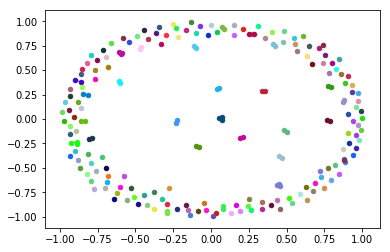

In [867]:
partition = community.best_partition(line_graph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(line_graph)
count = 0
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(line_graph, pos, list_nodes, node_size = 20,
                                node_color = color_set[count])
    count = count + 1


nx.draw_networkx_edges(line_graph, pos, alpha=0.5)
plt.show()

In [868]:
community.modularity(partition, line_graph)

0.9532871972318343

In [869]:
ground_truth_label = {}
for key in link_dict:
    label = link_dict[key][4]
    ground_truth_label.update({key : label})

In [870]:
community.modularity(ground_truth_label, line_graph)

0.40224913494809694

# Some Testing Score

In [30]:
day = 24*60*60
def thread_score(thread, alpha = 1, beta = 0.01, gamma = 1):
    thread = sorted(thread, key = time_stamp)
    num_of_links = len(thread)
    nodes = []
    for link in thread:
        for node in link[1:3]:
            if node not in nodes:
                nodes.append(node)
    num_of_nodes = len(nodes)
    
    intercontact_time = []
    if num_of_links == 1:
        return 0.5
    else:
        for i in range(num_of_links - 1):
            intercontact_time.append((thread[i+1][0] - thread[i][0])/day)
            
        duration = 0
        for t in intercontact_time:
            duration += t
        expectation = duration / len(intercontact_time)
        
        variance = 0
        for t in intercontact_time:
            variance += (t - expectation)**2
        variance = variance / len(intercontact_time)
        
    return num_of_links ** gamma / ( num_of_nodes + beta * duration + alpha * variance)

def partition_value(partition, alpha = 1, beta = 0.01, gamma = 1):
    result = 0
    num_edges = 0
    for thread in partition:
        num_edges += len(thread)
    for thread in partition:
        result += thread_score(thread, alpha, beta, gamma)
    return result / num_edges

In [118]:
test_thread_1 = []
test_thread_2 = []
whole_data = []
i = 0
for index in threads_dict:
    if i < 100:
        test_thread_1.append(threads_dict[index])
    elif i < 200:
        test_thread_2.append(threads_dict[index])
    else:
        break
    whole_data.append(threads_dict[index])
    i +=1

In [32]:
def equal_size_partition(data, size):
    partition = []
    i = 0
    tmp = []
    for thread in data:
        for link in thread:
            tmp.append(link)
            i = i+1
            if i > size:
                partition.append(tmp)
                i = 0
                tmp = []
    return partition

In [33]:
def single_element_partition(data):
    partition = []
    for thread in data:
        for link in thread:
            partition.append([link])
    return partition

In [34]:
def one_big_partition(data):
    big_thread = []
    for thread in data:
        for link in thread:
            big_thread.append(link)
    return [big_thread]

In [35]:
def parameter_test(true_partition, partitions, alpha, beta, gamma):
    score = partition_value(true_partition, alpha, beta, gamma)
    for part in partitions:
        s = partition_value(part, alpha, beta, gamma)
        if score < s:
            return False
    return True

In [119]:
equal_size_partition_1 = equal_size_partition(test_thread_1, 5)
equal_size_partition_2 = equal_size_partition(test_thread_2, 5)

single_element_threads_1 = single_element_partition(test_thread_1)
single_element_threads_2 = single_element_partition(test_thread_2)

whole_partition_1 = one_big_partition(test_thread_1)
whole_partition_2 = one_big_partition(test_thread_2)

links_1 = []
links_2 = []
for thread in test_thread_1:
    for link in thread:
        links_1.append(link)
        
for thread in test_thread_2:
    for link in thread:
        links_2.append(link)
la_1 = greedy_partition(links_1, break_time = 1300)
la_2 = greedy_partition(links_2, break_time = 1300)

partitions = [equal_size_partition_1, single_element_threads_1, la_1, whole_partition_1]

In [15]:
# grid search
a = []
b = []
c = []
for i in range(10):
    a.append(0.01 + i*0.4)
    b.append(0.1 + i*0.5)
    c.append(1 + 0.1*i)

In [16]:
num_passed = 0
for alpha in a:
    for beta in b:
        for gamma in c:
            passed = parameter_test(test_thread_1, partitions, alpha, beta, gamma)
            if passed:
                num_passed += 1
                #print("------------------")
                #print(alpha)f
                #print(beta)
                #print(gamma)

------------------
0.01
0.1
1.7000000000000002
------------------
0.01
0.1
1.8
------------------
0.01
0.6
1.9
------------------
0.41000000000000003
0.1
1.7000000000000002
------------------
0.41000000000000003
0.6
1.9
------------------
0.81
0.1
1.7000000000000002
------------------
0.81
0.6
1.9
------------------
1.2100000000000002
0.6
1.9


In [30]:
partition_value(test_thread_2, 0.81, 0.1, 1.7)

119.95724080493856

In [24]:
partition_value(equal_size_partition_2, 0.81, 0.1, 1.7)

84.07557690777188

In [25]:
partition_value(single_element_threads_2, 0.81, 0.1, 1.7)

111.0

In [26]:
partition_value(la_2, 0.81, 0.1, 1.7)

97.9851768503056

In [27]:
partition_value(whole_partition_2, 0.81, 0.1, 1.7)

21.433315586861053

#### Cross Validation

In [36]:
def grid_search(a, b, c, true_partition, partitions):
    for alpha in a:
        for beta in b:
            for gamma in c:
                passed = parameter_test(true_partition, partitions, alpha, beta, gamma)
                if passed:
                    return [alpha, beta, gamma]
    print('all fail')

In [109]:
import math
def cross_validation(data, training_index, ratio = 1/2, alpha_step = 0.2, beta_step = 0.5, gamma_step = 0.7): 
    #from starting_index to starting_index + 150 (wraped if overflow) is for learning
    #ratio is train / whole data, the rest is for test
    w = 0 # for wraping
    learning_data = []
    testing_data = []
    train_size = math.floor(len(data) * ratio)
    test_size = len(data) - train_size
    for i in range(training_index, training_index + train_size):
        if i < len(data):
            learning_data.append(data[i])
        else:
            learning_data.append(data[w])
            w += 1

    if w > 0:
        for j in range(test_size):
            testing_data.append(data[w + j])
    else:
        for i in range(training_index):
            testing_data.append(data[i])
        for i in range(training_index + train_size, len(data)):
            testing_data.append(data[i])
            
    equal_size_partition_1 = equal_size_partition(learning_data, 3)
    equal_size_partition_2 = equal_size_partition(testing_data, 3)

    single_element_threads_1 = single_element_partition(learning_data)
    single_element_threads_2 = single_element_partition(testing_data)

    whole_partition_1 = one_big_partition(learning_data)
    whole_partition_2 = one_big_partition(testing_data)

    links_1 = []
    links_2 = []
    for thread in learning_data:
        for link in thread:
            links_1.append(link)

    for thread in testing_data:
        for link in thread:
            links_2.append(link)
    la_1 = greedy_partition(links_1, break_time = 8000)
    la_2 = greedy_partition(links_2, break_time = 8000)
    
    a = []
    b = []
    c = []
    for i in range(10):
        a.append(0.01 + i*alpha_step)
        b.append(0 + i*beta_step)
        c.append(1 + i*gamma_step)

    partitions_1 = [whole_partition_1, single_element_threads_1, la_1, equal_size_partition_1]
    partitions_2 = [whole_partition_2, single_element_threads_2, la_2, equal_size_partition_2]
    
    alpha, beta, gamma = grid_search(a, b, c, learning_data, partitions_1)
    
    print("=======================================")
    print(alpha)
    print(beta)
    print(gamma)
    print("----------")
    print("train score:")
    print(partition_value(learning_data, alpha, beta, gamma))
    print("other train score:")
    for part in partitions_1:
        print(partition_value(part, alpha, beta, gamma))
    
    test_score = partition_value(testing_data, alpha, beta, gamma)
    print("----------")
    print('test score:')
    print(test_score)
    print('other test score:')
    for part in partitions_2:
        score = partition_value(part, alpha, beta, gamma)
        print(score)

In [110]:
# test with threads with more than 3 links
multiple_test_thread = []
for index in threads_dict:
    thread = threads_dict[index]
    if len(thread) > 3:
        multiple_test_thread.append(thread)

In [112]:
cross_validation(multiple_test_thread[0:600], 0, ratio = 1/2, alpha_step = 0.2, beta_step = 0.1, gamma_step = 0.75)

0.01
0.0
1.75
----------
train score:
0.7343248406853434
other train score:
0.4781197914688769
0.5
0.6501327450647456
0.5927874464596729
----------
test score:
0.8088095037693619
other test score:
0.5397499885578864
0.5
0.5830491253110704
0.6219290665254754


####  Function Plotting

In [180]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
links_1 = []
links_2 = []
for thread in test_thread_1:
    for link in thread:
        links_1.append(link)
        
for thread in test_thread_2:
    for link in thread:
        links_2.append(link)
la_1 = greedy_partition(links_1, break_time = 1300)
la_2 = greedy_partition(links_2, break_time = 1300)

<Figure size 432x288 with 0 Axes>

In [152]:
def constraint_fuction(partition, beta, gamma):
    score = partition_value(partition, 1, beta, gamma)
    gt_score = partition_value(test_thread_1, 1, beta, gamma)
    return gt_score - score

In [174]:
whole_partition_1 = one_big_partition(test_thread_1)
single_element_threads_1 = single_element_partition(test_thread_1)

In [154]:
constraint_fuction(whole_partition_1, 0.01, 1.7)

0.21197389510428083

In [181]:
beta = np.linspace(0, 1, 20)
gamma = np.linspace(1, 2, 20)

B, G = np.meshgrid(beta, gamma)
value = []
for b in beta:
    tmp = []
    for g in gamma:
        tmp.append(constraint_fuction(la_1, b, g))
    value.append(np.array(tmp))
value = np.array(value)

In [182]:
value.shape

(20, 20)

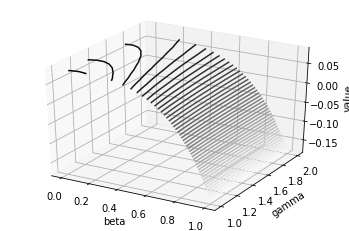

In [183]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(B, G, value, 50, cmap='binary')
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_zlabel('value');

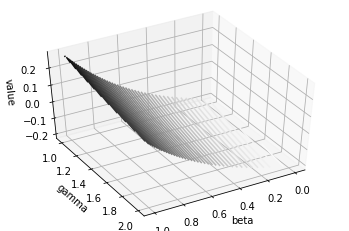

In [179]:
ax.view_init(45, 60)
fig